In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4693 - acc: 0.5404
Epoch 00001: val_loss improved from inf to 1.04390, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_9_conv_checkpoint/001-1.0439.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 1.4693 - acc: 0.5404 - val_loss: 1.0439 - val_acc: 0.6648
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5755 - acc: 0.8183
Epoch 00002: val_loss improved from 1.04390 to 0.40446, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_9_conv_checkpoint/002-0.4045.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.5755 - acc: 0.8183 - val_loss: 0.4045 - val_acc: 0.8786
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3826 - acc: 0.8780
Epoch 00003: val_loss did not improve from 0.40446
36805/36

36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9940
Epoch 00026: val_loss did not improve from 0.16288
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0219 - acc: 0.9940 - val_loss: 0.2014 - val_acc: 0.9462
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9943
Epoch 00027: val_loss did not improve from 0.16288
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0209 - acc: 0.9943 - val_loss: 0.1907 - val_acc: 0.9506
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9938
Epoch 00028: val_loss did not improve from 0.16288
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0216 - acc: 0.9938 - val_loss: 0.2370 - val_acc: 0.9357
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9886
Epoch 00029: val_loss did not improve from 0.16288
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9957
Epoch 00055: val_loss did not improve from 0.15663
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0141 - acc: 0.9957 - val_loss: 0.1703 - val_acc: 0.9567
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9977
Epoch 00056: val_loss did not improve from 0.15663
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0082 - acc: 0.9977 - val_loss: 0.1796 - val_acc: 0.9599
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9987
Epoch 00057: val_loss did not improve from 0.15663
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0051 - acc: 0.9988 - val_loss: 0.1899 - val_acc: 0.9548
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9983
Epoch 00058: val_loss did not improve from 0.15663
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9961
Epoch 00085: val_loss did not improve from 0.15663
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0133 - acc: 0.9960 - val_loss: 0.1751 - val_acc: 0.9616
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9979
Epoch 00086: val_loss did not improve from 0.15663
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0080 - acc: 0.9979 - val_loss: 0.1749 - val_acc: 0.9620
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9992
Epoch 00087: val_loss did not improve from 0.15663
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0031 - acc: 0.9992 - val_loss: 0.1866 - val_acc: 0.9592
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9993
Epoch 00088: val_loss did not improve from 0.15663
36805/36805 [========

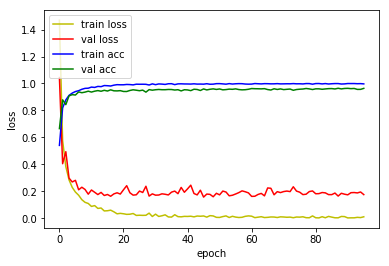

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2128 - acc: 0.9493
Loss: 0.2127867239213095 Accuracy: 0.949325



In [10]:
for i in range(9, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_BN_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None

4815/4815 [==============================] - 7s 2ms/sample - loss: 1.2689 - acc: 0.6521
Loss: 1.268929294584201 Accuracy: 0.65212876

1D_CNN_custom_conv_3_VGG_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_123 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_124 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)  (Non

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.6074 - acc: 0.8349
Loss: 0.6074317322589403 Accuracy: 0.83489096

1D_CNN_custom_conv_3_VGG_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_147 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_148 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation)  (No

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2028 - acc: 0.9423
Loss: 0.2028081684592852 Accuracy: 0.9422638

1D_CNN_custom_conv_3_VGG_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2128 - acc: 0.9493
Loss: 0.2127867239213095 Accuracy: 0.949325
